In [ ]:
# You will need PyBaMM to run this script
%pip install pybamm==24.9.0

In [ ]:
from TDGSA import simulator, distribution, time_dependent_sensitivity_analysis

import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

scale_factor = 4    # reduce current by a factor of 4 to avoid numerical issues

PCE_ORDER = 4       # choose order of PCE
NUM_SAMPLES = 500   # optimal number of samples = 210

## model setup
def battery_model(params):
    dfn = pybamm.lithium_ion.DFN()
    model_params = dfn.default_parameter_values
    # import drive cycle from file
    drive_cycle = pd.read_csv(
        "US06.csv", comment="#", header=None
    ).to_numpy()
    # create interpolant
    current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], drive_cycle[:, 1]/scale_factor, pybamm.t)
    # set drive cycle
    model_params["Current function [A]"] = current_interpolant  
    # set param values
    model_params["Negative electrode porosity"] = params[0]
    model_params["Positive electrode porosity"] = params[1]
    model_params["Negative particle radius [m]"] = params[2]
    model_params["Positive particle radius [m]"] = params[3]
    
    sim_US06_1 = pybamm.Simulation(
    dfn, parameter_values=model_params, solver=pybamm.CasadiSolver(mode="fast")
    )
    sol_US06_1 = sim_US06_1.solve(drive_cycle[:, 0])
    t_sol = sol_US06_1["Time [s]"].entries
    V_sol = sol_US06_1["Voltage [V]"](t_sol)
    return V_sol
    

Text(0, 0.5, 'Voltage / V')

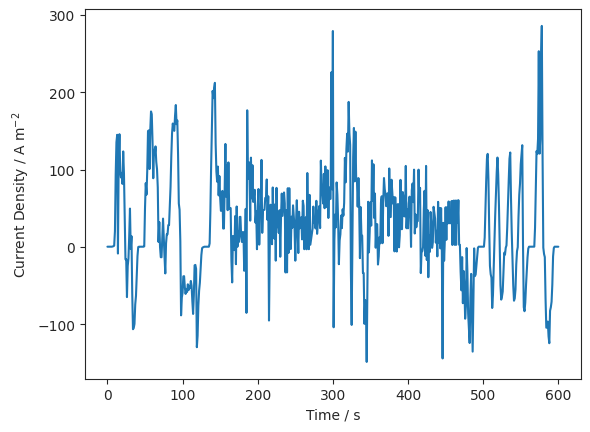

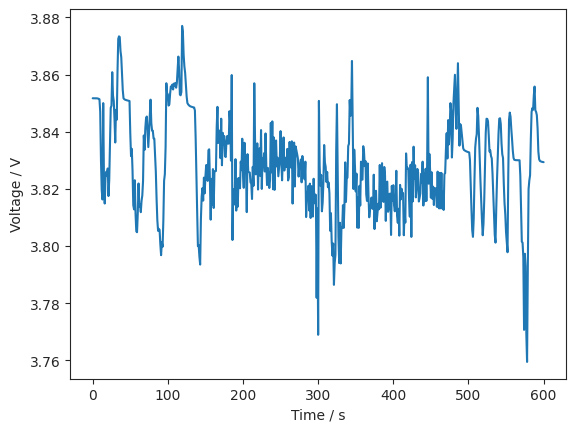

In [3]:
dfn = pybamm.lithium_ion.DFN()
model_params = dfn.default_parameter_values
# import drive cycle from file
drive_cycle = pd.read_csv(
    "US06.csv", comment="#", header=None
).to_numpy()
# create interpolant
current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], drive_cycle[:, 1]/scale_factor, pybamm.t)
# set drive cycle
model_params["Current function [A]"] = current_interpolant

def j0_neg(c_e, c_s_surf, c_s_max, T):
    return 96485.3321 * 1e-10 * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf)**0.5
    
def j0_pos(c_e, c_s_surf, c_s_max, T):
    return 96485.3321 * 1e-10 * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf)**0.5

# set param values
model_params["Negative electrode porosity"] = 0.3
model_params["Positive electrode porosity"] = 0.4
model_params["Negative particle radius [m]"] = 0.8e-5
model_params["Positive particle radius [m]"] = 1e-5
model_params['Negative electrode exchange-current density [A.m-2]'] = j0_neg
model_params['Positive electrode exchange-current density [A.m-2]'] = j0_pos


sim_US06_1 = pybamm.Simulation(
dfn, parameter_values=model_params, solver=pybamm.CasadiSolver(mode="fast")
)
sol_US06_1 = sim_US06_1.solve()
t_sol = sol_US06_1["Time [s]"].entries
V_sol = sol_US06_1["Voltage [V]"](t_sol)

sns.set_style("ticks")
plt.figure()
plt.plot(drive_cycle[:,0], drive_cycle[:,1]/(model_params["Electrode height [m]"]*model_params["Electrode width [m]"]))
plt.xlabel("Time / s")
plt.ylabel("Current Density / A m$^{-2}$")

plt.figure()
plt.plot(t_sol, V_sol)
plt.xlabel("Time / s")
plt.ylabel("Voltage / V")

In [4]:
## Define parameter distribution

num_samples = NUM_SAMPLES

my_dist_dict = {
    r"$\Phi_{neg}$": ("uniform", [0.25, 0.5]),
    r"$\Phi_{pos}$": ("uniform", [0.2, 0.65]),
    r"$R_{neg}$": ("uniform", [0.2e-5, 1.2e-5]),
    r"$R_{pos}$": ("uniform", [0.1e-5, 1e-5])
}

my_distribution = distribution(my_dist_dict)
my_simulator = simulator(battery_model, t_sol)

my_tdsa = time_dependent_sensitivity_analysis(my_simulator, my_distribution)

my_params, my_output = my_tdsa.sample_params_and_run_simulator(num_samples)

Sampling parameters ...

Running simulator ...



100%|██████████| 500/500 [21:14<00:00,  2.55s/it]


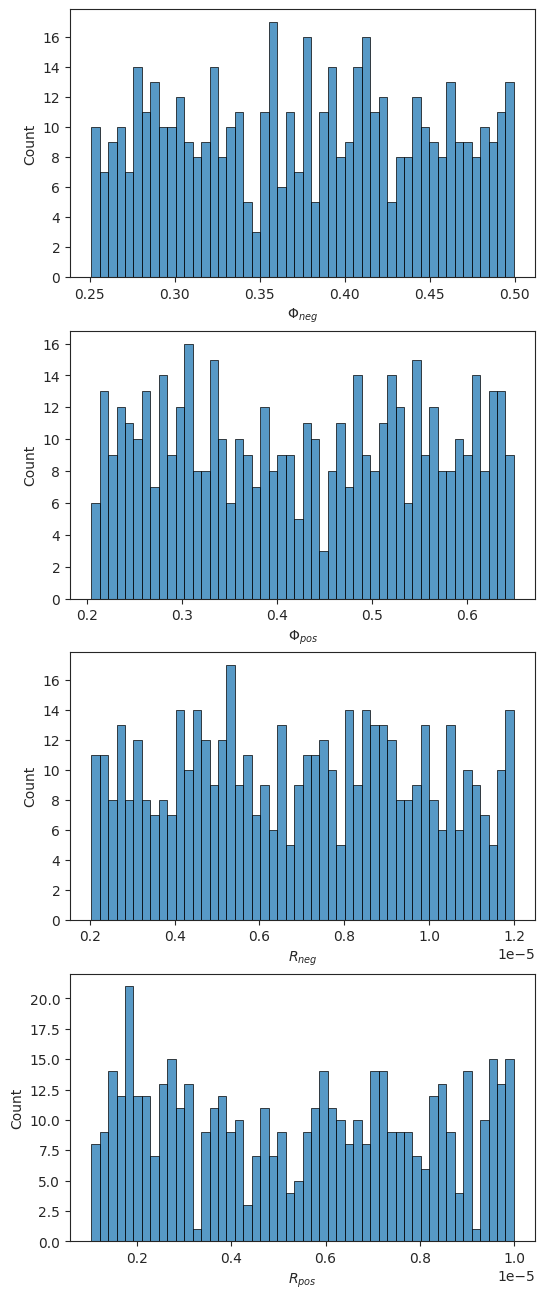

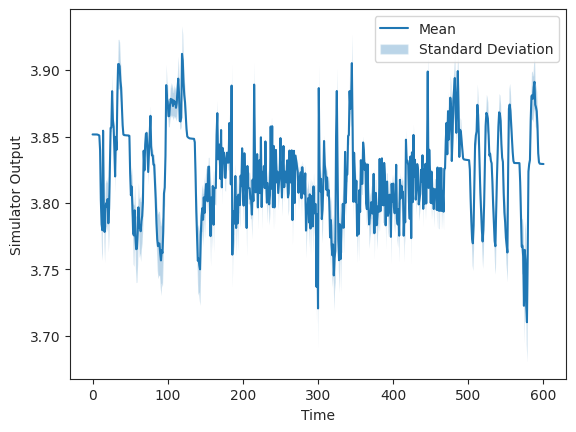

In [5]:
## Plot parameters
my_tdsa.plot("sampled_parameters")

## Plot output
my_tdsa.plot("simulator_output")

Generating PCE expansion ...

Fitting surrogate models ...



100%|██████████| 20/20 [00:00<00:00, 31.85it/s]


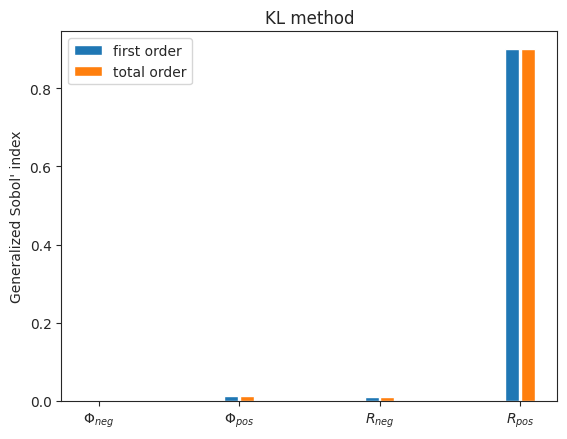

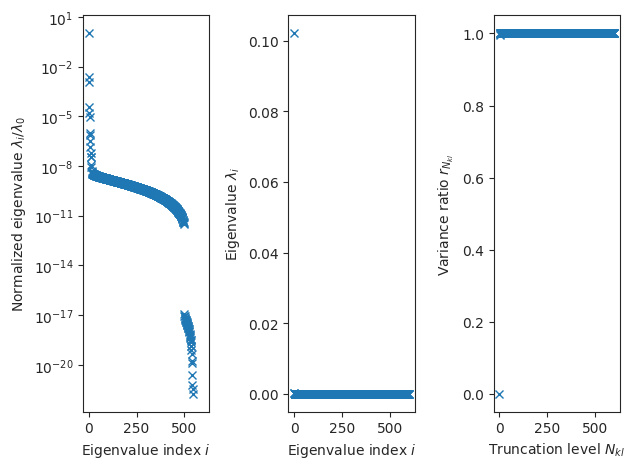

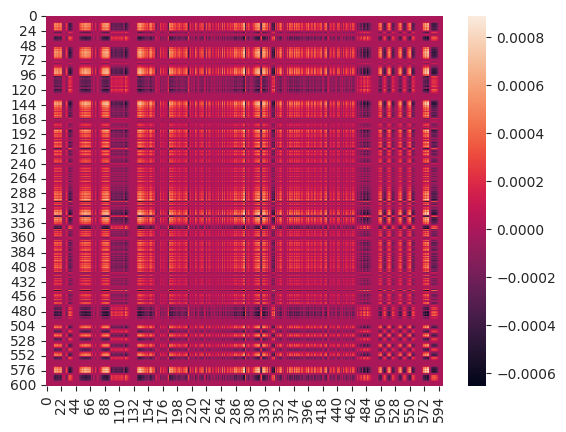

In [6]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'KL'
#===============================================================================#

sobol_indices_KL = my_tdsa.compute_sobol_indices("KL", num_timesteps_quadrature=601, KL_truncation_level=20, PCE_order=PCE_ORDER)

my_tdsa.plot("sobol_indices")

my_tdsa.plot("eigenvalue_spectrum")

my_tdsa.plot("covariance_matrix")

Generating PCE expansion ...

Fitting surrogate models ...



100%|██████████| 601/601 [00:06<00:00, 92.80it/s] 


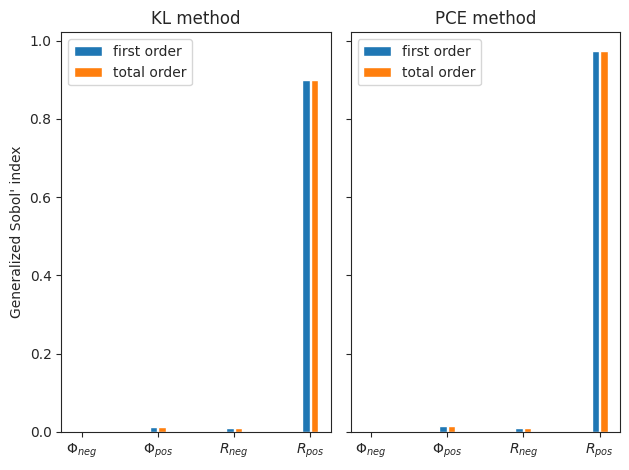

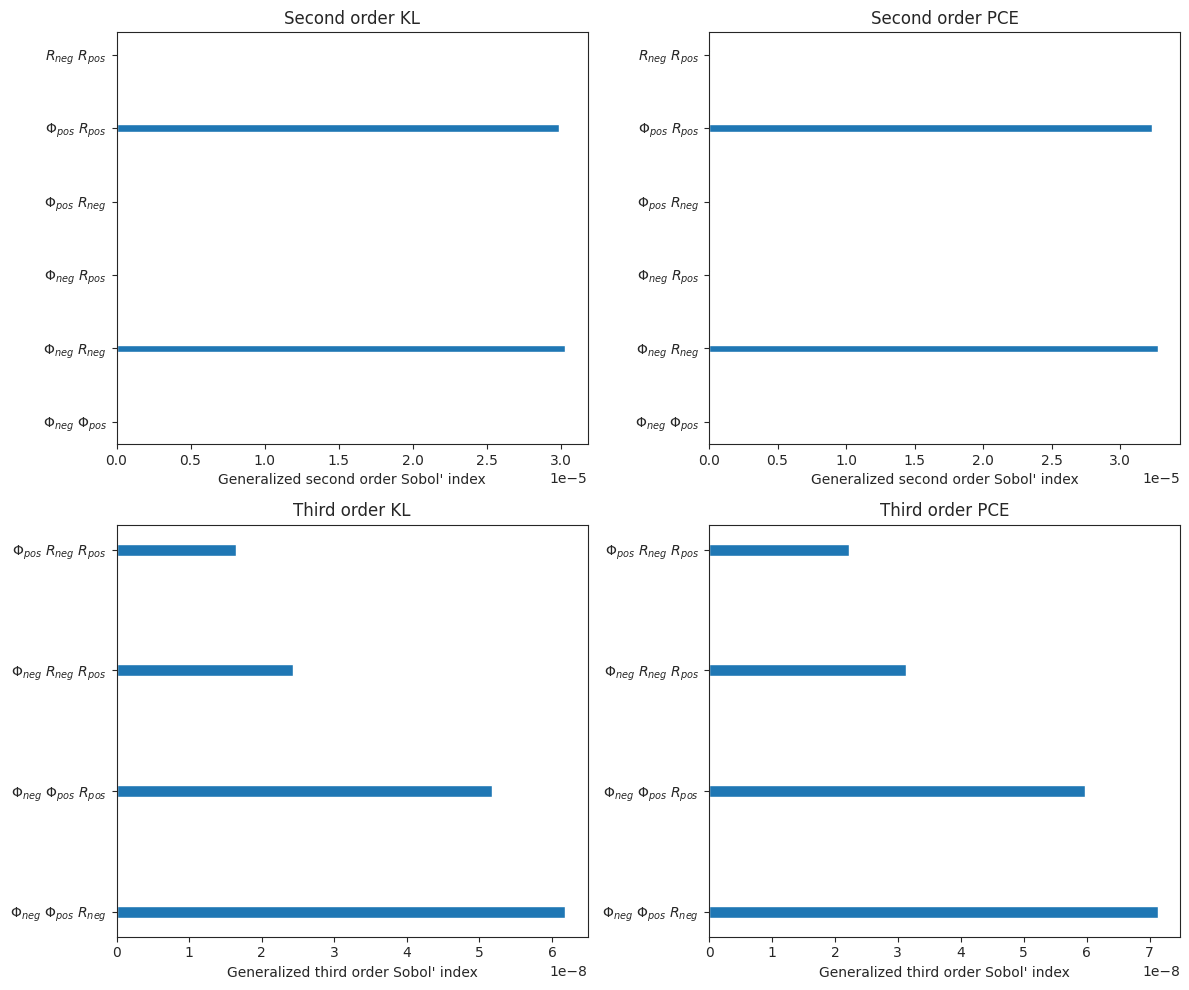

In [9]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'PCE'
#===============================================================================#

sobol_indices_PCE = my_tdsa.compute_sobol_indices("PCE", num_timesteps_quadrature=601, PCE_ORDER=PCE_ORDER)

my_tdsa.plot("sobol_indices")

second_order_sobol_indices_PCE, param_combinations_sec = my_tdsa.compute_second_order_sobol_indices("PCE")
third_order_sobol_indices_PCE, param_combinations_third = my_tdsa.compute_third_order_sobol_indices("PCE")
second_order_sobol_indices_KL, param_combinations_sec = my_tdsa.compute_second_order_sobol_indices("KL")
third_order_sobol_indices_KL, param_combinations_third = my_tdsa.compute_third_order_sobol_indices("KL")

my_tdsa.plot("higher_order_sobol_indices")

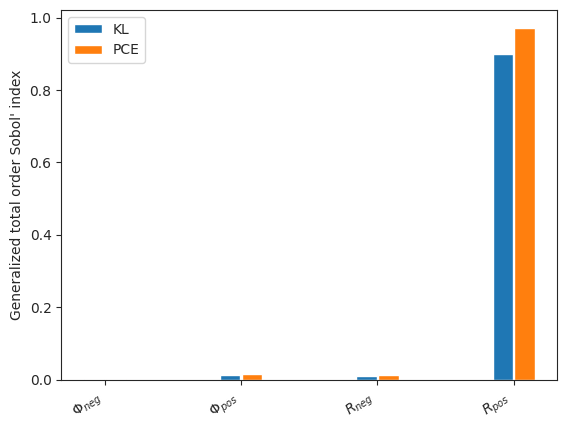

In [8]:
fig, ax = plt.subplots()
x = np.arange(len(my_tdsa.param_names))
ax.bar(x-0.08, sobol_indices_KL["total"], width=0.15, label="KL")
ax.bar(x+0.08, sobol_indices_PCE["total"], width=0.15, label="PCE")
ax.set_xticks(x, my_tdsa.param_names, rotation=35, ha="right")
ax.set_ylabel("Generalized total order Sobol' index")
ax.legend()